<a href="https://colab.research.google.com/github/jaketerrito/speedchallenge/blob/master/Feedforward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/jaketerrito/speedchallenge/raw/master/data/train.mp4
!wget https://github.com/jaketerrito/speedchallenge/raw/master/data/train.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2 as cv

In [3]:
import numpy as np
import time
from os.path import splitext

def denseflow(fname, resize_factor):
    cap = cv.VideoCapture(fname)
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")
        exit()

    # Get the video dimensions, 3 is the ordinal value of CV_CAP_PROP_FRAME_WIDTH, 4 is CV_CAP_PROP_FRAME_HEIGHT
    # Also resize them because these images are too big
    width = int(cap.get(3) / resize_factor)
    height = int(cap.get(4) / resize_factor)
    shape = (width,height)
    size = int(cap.get(7))
    ret, frame1 = cap.read()
    frame1 = cv.resize(frame1,shape)
    prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
    hsv = np.zeros_like(frame1)
    hsv[...,1] = 255

    frames = np.zeros((size,hsv.shape[0],hsv.shape[1],3))
    frames[0] = hsv

    fcount = 1
    t = time.time()

    while(1):
        ret, frame2 = cap.read()
        if not ret:
            break
        frame2 = cv.resize(frame2,shape)
        next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
        flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
        hsv[...,0] = ang*180/np.pi/2
        hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
        frames[fcount] = hsv
        prvs = next
        fcount += 1
    cap.release()

    f, ext = splitext(fname)
    #np.savez(f+'_op', frames)
    return frames

In [4]:
fname = "data/train.mp4"
'''
try:
    f, ext = splitext(fname)
    with np.load(f + '_op.npz') as data:
        video = data['arr_0']
except:
    print("Could not find preprocessed video, creating it now")
'''
video = denseflow(fname,4)

width = video.shape[2]
height = video.shape[1]
video_size = len(video)

video = video/255

In [5]:
import random
def data_generator(video, speeds, batch_size, sequence_length):
    while True:
        x = []
        y = []
        while len(x) < batch_size:
            frame_num = random.randrange(sequence_length,len(video))
            sequence = video[frame_num-sequence_length:frame_num]
            '''
            flip = random.choice([True,False])
            angle = random.uniform(-20,20)
            scale = random.uniform(.8,1.2)

            for i, image in enumerate(sequence):
                # Augmentation
                image = skimage.transform.rescale(image, scale=scale)
                image = skimage.transform.resize(image, output_shape=sequence[i].shape, mode='constant')
                image = skimage.transform.rotate(image, angle=angle)

                # Really need to see the types of values before we add this noise
                image = image + np.random.normal(scale=.5,size=image.shape)

                #normalize input!
                image = image / 255
                sequence[i] = image
            '''
            x.append(sequence)
            y.append(speeds[frame_num-1])
        yield np.array(x), np.array(y)

def prediction_generator(video, sequence_length):
    i = 0
    while True:
        yield np.array([video[i:i+sequence_length]])
        i += 1

In [6]:
print("Processing speeds.")
with open('data/train.txt') as f:
    speeds = f.readlines()
    speeds = np.array([float(x.strip()) for x in speeds])
speeds = speeds

Processing speeds.


In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, MaxPooling2D, Dropout, LeakyReLU, PReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adam

In [10]:
batch_size = 16
sequence_length = 8
epochs = 20
split = .9

width = video.shape[2]
height = video.shape[1]
video_size = len(video)

train_gen = data_generator(video[:int(video_size*split)], speeds[:int(video_size*split)], batch_size, sequence_length)
val_gen = data_generator(video[int(video_size*split):], speeds[int(video_size*split):], batch_size, sequence_length)

# Will return a feature and label set.	
# Features are a list of image sequences in the form: (sequence_length, img_height, img_width, dimensions)
inputs = Input((sequence_length,height,width,3))
# A convolution being applied to each image seperately
x = Conv3D(32,(1,3,3),strides=(1,2,2),activation=None)(inputs)
x = LeakyReLU(alpha=0.1)(x)
x = Conv3D(32,(3,3,3),strides=(2,2,2),activation=None)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Conv3D(32,(3,3,3),strides=(2,2,2),activation=None)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = Dropout(.75)(x)
x = Dense(32,activation=None)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(.5)(x)
x = Dense(16,activation=None)(x)
x = LeakyReLU(alpha=0.1)(x)
outputs = Dense(1,activation=None)(x)

model = Model(inputs=inputs,outputs=outputs) 
model.compile(Adam(lr=.001),loss='mean_squared_error')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8, 120, 160, 3)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 59, 79, 32)     896       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 59, 79, 32)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 3, 29, 39, 32)     27680     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 3, 29, 39, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 1, 14, 19, 32)     27680     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1, 14, 19, 32)     0         
__________

In [11]:
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=int(video_size*split/batch_size), 
    validation_data=val_gen, 
    validation_steps=int(video_size*(1-split)/batch_size),
    epochs=epochs,
    verbose=True,
    callbacks=[ModelCheckpoint('./data/weights.hdf5',save_best_only=True)]
)

Epoch 1/20
1147/1147 [==============================] - 78s 68ms/step - loss: 33.8208 - val_loss: 8.1782
Epoch 2/20
1147/1147 [==============================] - 79s 69ms/step - loss: 13.8829 - val_loss: 7.6046
Epoch 3/20
1147/1147 [==============================] - 77s 67ms/step - loss: 10.2470 - val_loss: 5.8708
Epoch 4/20
1147/1147 [==============================] - 79s 69ms/step - loss: 8.4741 - val_loss: 6.9167
Epoch 5/20
1147/1147 [==============================] - 79s 69ms/step - loss: 7.3147 - val_loss: 6.7612
Epoch 6/20
1147/1147 [==============================] - 79s 69ms/step - loss: 6.5095 - val_loss: 5.5376
Epoch 7/20
1147/1147 [==============================] - 78s 68ms/step - loss: 5.9906 - val_loss: 5.3288
Epoch 8/20
1147/1147 [==============================] - 77s 67ms/step - loss: 5.4390 - val_loss: 6.0032
Epoch 9/20
1147/1147 [==============================] - 77s 67ms/step - loss: 5.0765 - val_loss: 5.7727
Epoch 10/20
1147/1147 [==============================] - 77s 

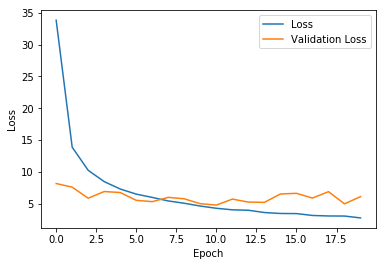

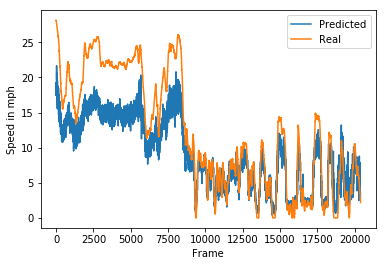

In [12]:
model2 = load_model(filepath='./data/weights.hdf5')
model2.compile(RMSprop(),loss='mean_squared_error')

# Plot the training loss against the validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.savefig(fname='./data/lossplot')
plt.show()

plt.clf()

pred_gen = prediction_generator(video, sequence_length)

# Plotting predicted speeds against real speeds
plt.plot(model2.predict_generator(pred_gen, steps=video_size-sequence_length))
plt.plot(speeds)
plt.xlabel('Frame')
plt.ylabel('Speed in mph')
plt.legend(['Predicted', 'Real'])
plt.savefig(fname='./data/speedplot')
plt.show()